<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/ProjetIA/ProjetIA_Adversarial_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from random import random
import pandas as pd
import matplotlib.pyplot as plt

import datetime


cuda = torch.cuda.is_available()

## From adversarial examples to training robust models

In the previous notebooks, we focused on methods for solving the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this notebook, we will focus on training a robust classifier. More precisly, we aim at solving following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

# Functions
1. Train a robust classifier using Adversarial Training with a specific norm
2. Evaluate your classifier on natural and adversarial examples crafted with the norm of the training and other norms
3. Make an analysis and conclude

In [5]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)



Files already downloaded and verified
Files already downloaded and verified


In [6]:
class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()
    # First Convolutional Layer: Input channels = 3, Output channels = 32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    # First Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    # Second Convolutional Layer: Input channels = 32, Output channels = 64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # Second Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)  # Assuming 10 output classes


  def forward(self, x):
    # First convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool1(nn.functional.relu(self.conv1(x)))
    # Second convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool2(nn.functional.relu(self.conv2(x)))

    # Flatten the output for the fully connected layers
    x = x.view(-1, 64 * 8 * 8)  # Flattening the output from conv layers

    # First fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc1(x))
    # Second fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc2(x))
    # Output layer: FC
    x = self.fc3(x)

    return x

In [7]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    self.model = model
    self.eps = eps


  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    delta = torch.zeros_like(x, requires_grad=True)
    # code here ...
    criterion = nn.CrossEntropyLoss()
    output = self.model(x + delta)
    loss = criterion(output, y)
    loss.backward()
    # Use variable.grad.detach() to retreive the gradient with respect to a loss
    grad = delta.grad.detach()
    delta = self.eps * grad.sign()

    return delta


class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # delta = torch.randn_like(x, requires_grad=True)
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(self.num_iter):
      adv = torch.clamp(x + delta, 0, 1)
      loss = nn.CrossEntropyLoss()(self.model(adv), y)
      loss.backward()
      delta.data = (delta.data + self.alpha * delta.grad.sign()).clamp(-self.eps, self.eps)
      delta.grad.zero_()
    return delta.detach()


class ProjectedGradientDescentL2:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):

        # initialize the perturbation delta to zero, and require gradient for optimization
        delta = torch.zeros_like(x, requires_grad=True)

        # iteratively compute adversarial perturbations
        for t in range(self.num_iter):
            # add perturbation to the input and clamp values between [0, 1]
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]
            output = self.model(adv)
            loss = nn.CrossEntropyLoss()(output, y)
            mask = 1 * (torch.max(output, 1)[1] == y)
            loss.backward()
            grad_norm = torch.norm(delta.grad.detach(), p=2, dim=[1, 2, 3])
            normalized_grad = delta.grad.detach() / (grad_norm.view(-1, 1, 1, 1) + 1e-10)
            delta.data += self.alpha * normalized_grad * mask.view(-1, 1, 1, 1)
            shape_perturb = delta.data.shape
            delta.data = torch.renorm(delta.detach().reshape(delta.size(0), -1), p=2, dim=1, maxnorm=self.eps)
            delta.data = delta.data.reshape(*shape_perturb)
            delta.data = torch.clamp(x.data + delta.data, 0, 1) - x.data
            delta.grad.zero_()

        # Return the computed adversarial perturbation
        return delta.detach()


In [8]:
def adversarial_train_model(model, criterion, optimizer, loader, epochs=5, attack=None, perc_attacked=1, verbose=True):
  """Function to train the model"""

  f = 0
  train_losses = []
  for e in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        if cuda:
          images, labels = images.cuda(), labels.cuda()
        f = f + 1
        model.train() # - Set the model to train mode
        optimizer.zero_grad()# - Reset the optimizer

        if attack is None:
          output = model(images)
        else:
          if random() < perc_attacked:
            delta = attack.compute(images, labels)
            output = model(images + delta)
          else:
            output = model(images)

        loss = criterion(output, labels)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights
    if verbose:
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, loss.item()))
    train_losses.append(loss.item()) #save loss

  return train_losses


In [9]:
def eval_model(model, loader, attack=None, attack_name='', verbose=True):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs

  if verbose:
    if attack is None:
      print('Clean Accuracy, accuracy on testset: {:.4f}'.format(accuracy))
    else:
      print('Robust Accuracy, accuracy on testset with attack {}: {:.4f}'.format(attack_name, accuracy))

  return accuracy

# Test attack

In [10]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs


## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff


### A. Training Strategies for Robustness

#### **Standard Training**

In [21]:
print('Model without attack:')
# adverserial training with PGD
model_noattack = ConvModel()
if cuda:
  model_noattack = model_noattack.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_noattack.parameters(), lr=0.001)
#define attack
attack = None
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_noattack, criterion, opt, train_loader, epochs, attack, perc_attacked, verbose=True)

Model without attack:
Epoch: 1 	Training Loss: 1.364875
Epoch: 2 	Training Loss: 1.401080
Epoch: 3 	Training Loss: 0.982242
Epoch: 4 	Training Loss: 1.007898
Epoch: 5 	Training Loss: 0.805058
Epoch: 6 	Training Loss: 0.742349
Epoch: 7 	Training Loss: 0.740160
Epoch: 8 	Training Loss: 0.487274
Epoch: 9 	Training Loss: 0.495030
Epoch: 10 	Training Loss: 0.581656
Epoch: 11 	Training Loss: 0.392532
Epoch: 12 	Training Loss: 0.473741
Epoch: 13 	Training Loss: 0.357386
Epoch: 14 	Training Loss: 0.405414
Epoch: 15 	Training Loss: 0.371652
Epoch: 16 	Training Loss: 0.215856
Epoch: 17 	Training Loss: 0.302733
Epoch: 18 	Training Loss: 0.125440
Epoch: 19 	Training Loss: 0.212485
Epoch: 20 	Training Loss: 0.123342


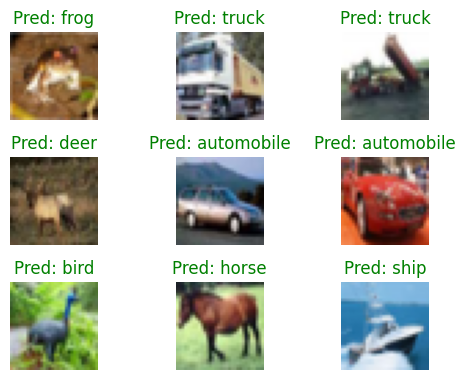

In [22]:
# plot natural images
output = model_noattack(imgs)
plot_images(imgs, labels, output, 3, 3)

In [28]:
#Defining my attacks
fgsm = FastGradientSignMethod(model_noattack, 0.03)
pdg_l0 = ProjectedGradientDescent(model_noattack, eps=0.03, alpha=0.006, num_iter=10)
pdg_l2 = ProjectedGradientDescentL2(model_noattack, eps=0.15, alpha=0.075, num_iter=10)


In [29]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_noattack, test_loader)

#Robust Accuracy: eval model attacked test set
eval_model(model_noattack, test_loader, fgsm, 'FGSM')
eval_model(model_noattack, test_loader, pdg_l0, 'PGD L0')
eval_model(model_noattack, test_loader, pdg_l2, 'PGD L2')


Clean Accuracy, accuracy on testset: 0.9626
Robust Accuracy, accuracy on testset with attack FGSM: 0.0333
Robust Accuracy, accuracy on testset with attack PGD L0: 0.0010
Robust Accuracy, accuracy on testset with attack PGD L2: 0.0306


0.03056

We see that our model is very sensitive to the different attacks, making drop the accuracy.

Target of the project is to improve the robust accuracy with adversarial training.

#### **Adversarial Training**

1. FGSM

In [30]:
print('Model with attack FGSM:')
# adverserial training with PGD
model_withattackFGSM = ConvModel()
if cuda:
  model_withattack = model_withattackFGSM.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackFGSM.parameters(), lr=0.01)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackFGSM, criterion, opt, train_loader, epochs,
                                       attack=fgsm, perc_attacked=perc_attacked, verbose=True)

Model with attack FGSM:
Epoch: 1 	Training Loss: 1.653429
Epoch: 2 	Training Loss: 1.227225
Epoch: 3 	Training Loss: 1.229817
Epoch: 4 	Training Loss: 1.318650
Epoch: 5 	Training Loss: 1.156626
Epoch: 6 	Training Loss: 1.194875
Epoch: 7 	Training Loss: 1.155684
Epoch: 8 	Training Loss: 1.035438
Epoch: 9 	Training Loss: 1.011621
Epoch: 10 	Training Loss: 0.951759
Epoch: 11 	Training Loss: 1.198825
Epoch: 12 	Training Loss: 0.846451
Epoch: 13 	Training Loss: 0.983389
Epoch: 14 	Training Loss: 0.549507
Epoch: 15 	Training Loss: 0.911181
Epoch: 16 	Training Loss: 0.769848
Epoch: 17 	Training Loss: 0.857418
Epoch: 18 	Training Loss: 0.952917
Epoch: 19 	Training Loss: 0.762260
Epoch: 20 	Training Loss: 0.635060


Classification with attacked img of a standard training


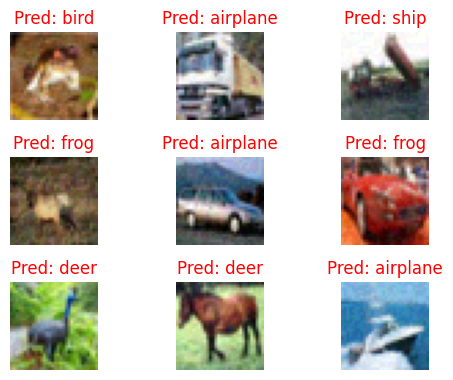

Classification with attacked img of an adversarial training


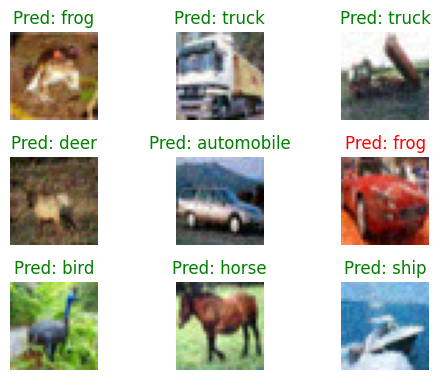

In [31]:
# plot natural images
delta = fgsm.compute(imgs, labels)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackFGSM(imgs+delta), M=3, N=3)

In [32]:
eval_model(model_withattackFGSM, test_loader, fgsm, 'FGSM')

Robust Accuracy, accuracy on testset with attack FGSM: 0.7639


0.76394

2. PGB L0

When using PGD for adversarial training, it's normal for the model to struggle with convergence compared to FGSM or standard training. This is because PGD generates stronger, more challenging adversarial examples through iterative optimization, making the training harder. PGD requires more careful tuning of hyperparameters like learning rate and attack step size. To help, consider adjusting the learning rate, experimenting with different PGD parameters, or using a mix of FGSM and PGD in the early stages of training.

In [34]:
print('Model with attack PGD:')
# adverserial training with PGD
model_withattackPGD = ConvModel()
if cuda:
  model_withattackPGD = model_withattackPGD.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGD.parameters(), lr=0.001)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGD, criterion, opt, train_loader, epochs, attack=pdg_l0, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD:
Epoch: 1 	Training Loss: 1.604661
Epoch: 2 	Training Loss: 1.300734
Epoch: 3 	Training Loss: 1.005098
Epoch: 4 	Training Loss: 0.863126
Epoch: 5 	Training Loss: 0.759508
Epoch: 6 	Training Loss: 0.496416
Epoch: 7 	Training Loss: 0.293168
Epoch: 8 	Training Loss: 0.401264
Epoch: 9 	Training Loss: 0.460500
Epoch: 10 	Training Loss: 0.421677
Epoch: 11 	Training Loss: 0.325643
Epoch: 12 	Training Loss: 0.293972
Epoch: 13 	Training Loss: 0.155869
Epoch: 14 	Training Loss: 0.208399
Epoch: 15 	Training Loss: 0.131826
Epoch: 16 	Training Loss: 0.110864
Epoch: 17 	Training Loss: 0.132238
Epoch: 18 	Training Loss: 0.057199
Epoch: 19 	Training Loss: 0.068721
Epoch: 20 	Training Loss: 0.076130


Classification with attacked img of a standard training


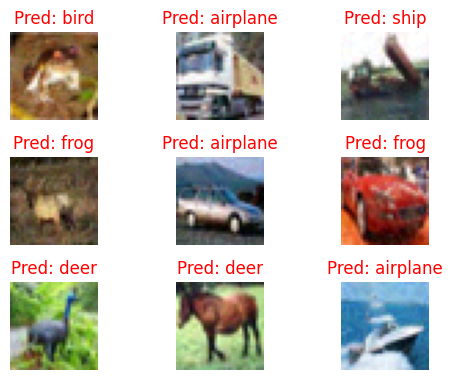

Classification with attacked img of an adversarial training


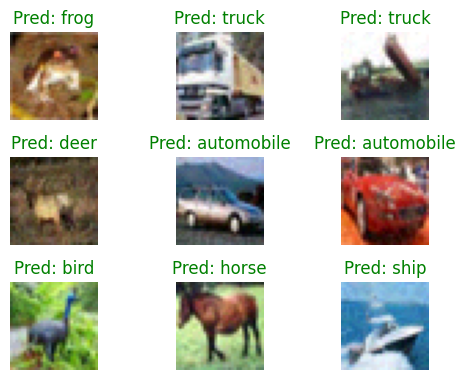

In [35]:
# plot natural images
delta = pdg_l0.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [76]:
eval_model(model_withattackPGD, test_loader, pdg_l0, 'PGD')


Robust Accuracy, accuracy on testset with attack PGD: 0.9839


0.98394

3. PGD L2

In [37]:
print('Model with attack PGD L2:')
# adverserial training with PGD
model_withattackPGDL2 = ConvModel()
if cuda:
  model_withattack = model_withattackPGDL2.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDL2.parameters(), lr=0.001)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGDL2, criterion, opt, train_loader, epochs, attack=pdg_l2, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L2:
Epoch: 1 	Training Loss: 1.288501
Epoch: 2 	Training Loss: 1.331219
Epoch: 3 	Training Loss: 1.244743
Epoch: 4 	Training Loss: 0.973364
Epoch: 5 	Training Loss: 0.973855
Epoch: 6 	Training Loss: 0.826778
Epoch: 7 	Training Loss: 0.814260
Epoch: 8 	Training Loss: 0.724021
Epoch: 9 	Training Loss: 0.653699
Epoch: 10 	Training Loss: 0.551169
Epoch: 11 	Training Loss: 0.482213
Epoch: 12 	Training Loss: 0.418827
Epoch: 13 	Training Loss: 0.441891
Epoch: 14 	Training Loss: 0.427133
Epoch: 15 	Training Loss: 0.640151
Epoch: 16 	Training Loss: 0.282624
Epoch: 17 	Training Loss: 0.317549
Epoch: 18 	Training Loss: 0.434058
Epoch: 19 	Training Loss: 0.345595
Epoch: 20 	Training Loss: 0.312915


Classification with attacked img of a standard training


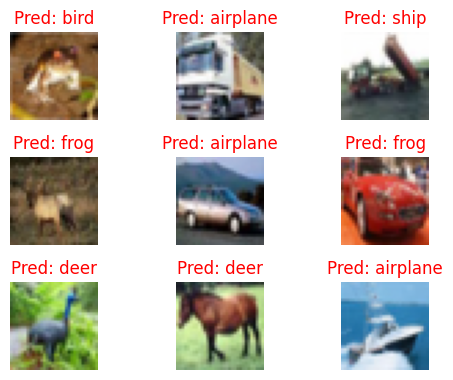

Classification with attacked img of an adversarial training


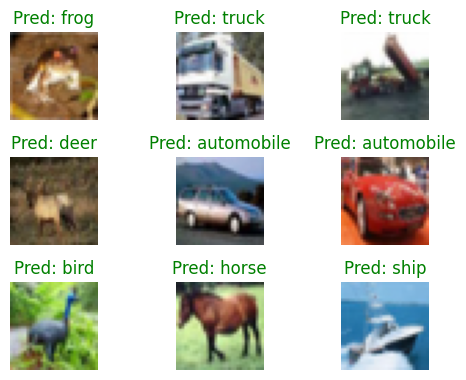

In [39]:
# plot natural images
delta = pdg_l2.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [40]:
eval_model(model_withattackPGDL2, test_loader, pdg_l2, 'PGD L2')


Robust Accuracy, accuracy on testset with attack PGD L2: 0.9477


0.94774

### B. Evaluating Robustness vs. Accuracy Tradeoff

In [64]:
res = {"Model": [], "Attack": [], "Accuracy": []}

models = [model_noattack, model_withattackFGSM, model_withattackPGD, model_withattackPGDL2]
models_name = ["model_noattack", "model_withattackFGSM", "model_withattackPGD", "model_withattackPGDL2"]
attacks = [None, fgsm, pdg_l0, pdg_l2]
attack_names = ["None", "FGSM", "PGD", "PGD L2"]

for model, model_name in zip(models, models_name):
  for attack, attack_name in zip(attacks, attack_names):
    res["Model"].append(model_name)
    res["Attack"].append(attack_name)
    res["Accuracy"].append(eval_model(model, test_loader, attack, attack_name, verbose=False))

    print(f'model: {model_name}, attack: {attack_name}')


model: model_noattack, attack: None
model: model_noattack, attack: FGSM
model: model_noattack, attack: PGD
model: model_noattack, attack: PGD L2
model: model_withattackFGSM, attack: None
model: model_withattackFGSM, attack: FGSM
model: model_withattackFGSM, attack: PGD
model: model_withattackFGSM, attack: PGD L2
model: model_withattackPGD, attack: None
model: model_withattackPGD, attack: FGSM
model: model_withattackPGD, attack: PGD
model: model_withattackPGD, attack: PGD L2
model: model_withattackPGDL2, attack: None
model: model_withattackPGDL2, attack: FGSM
model: model_withattackPGDL2, attack: PGD
model: model_withattackPGDL2, attack: PGD L2


In [65]:
pd.DataFrame(res).to_csv(f'/content/drive/MyDrive/Dauphine /Adversarial/res_{ts}.csv')


In [66]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(res)

# Pivot the DataFrame
pivot_df = df.pivot(index="Model", columns="Attack", values="Accuracy").fillna("-")


pivot_df[["None", "FGSM", "PGD", "PGD L2"]]

Attack,None,FGSM,PGD,PGD L2
Model,,,,
model_noattack,0.96262,0.03334,0.00100,0.03056
model_withattackFGSM,0.48746,0.76394,0.72478,0.54640
model_withattackPGD,0.58536,0.95592,0.98394,0.69094
model_withattackPGDL2,0.95826,0.73806,0.73158,0.94774


# Let's finetune our standard model with attacked images

In [67]:
# adverserial training with PGD
model_finetuned = ConvModel()
if cuda:
  model_finetuned = model_finetuned.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_finetuned.parameters(), lr=0.001)

# define epoch
epochs = 10

print("Training with standard model:")
train_losses = adversarial_train_model(model_finetuned, criterion, opt, train_loader,
                                       epochs, None, 1, verbose=True)
print("Finetuning with FGSM:")
train_losses = adversarial_train_model(model_finetuned, criterion, opt, train_loader,
                                       epochs, fgsm, 1, verbose=True)
print("Finetuning with PGD:")
train_losses = adversarial_train_model(model_finetuned, criterion, opt, train_loader,
                                       epochs, pdg_l0, 1, verbose=True)
print("Finetuning with PGD L2:")
train_losses = adversarial_train_model(model_finetuned, criterion, opt, train_loader,
                                       epochs, pdg_l2, 1, verbose=True)


Training with standard model:
Epoch: 1 	Training Loss: 1.326604
Epoch: 2 	Training Loss: 1.140509
Epoch: 3 	Training Loss: 1.038080
Epoch: 4 	Training Loss: 1.006160
Epoch: 5 	Training Loss: 0.752784
Epoch: 6 	Training Loss: 0.970272
Epoch: 7 	Training Loss: 0.976000
Epoch: 8 	Training Loss: 0.747851
Epoch: 9 	Training Loss: 0.660871
Epoch: 10 	Training Loss: 0.560102
Finetuning with FGSM:
Epoch: 1 	Training Loss: 0.943491
Epoch: 2 	Training Loss: 0.559360
Epoch: 3 	Training Loss: 0.628561
Epoch: 4 	Training Loss: 0.496383
Epoch: 5 	Training Loss: 0.390764
Epoch: 6 	Training Loss: 0.312777
Epoch: 7 	Training Loss: 0.181370
Epoch: 8 	Training Loss: 0.200228
Epoch: 9 	Training Loss: 0.109373
Epoch: 10 	Training Loss: 0.076628
Finetuning with PGD L0:
Epoch: 1 	Training Loss: 0.205002
Epoch: 2 	Training Loss: 0.152433
Epoch: 3 	Training Loss: 0.065715
Epoch: 4 	Training Loss: 0.149632
Epoch: 5 	Training Loss: 0.177071
Epoch: 6 	Training Loss: 0.093960
Epoch: 7 	Training Loss: 0.160930
Epoc

In [68]:
res_finetuned = {"Model": [], "Attack": [], "Accuracy": []}

models = [model_finetuned]
models_name = ["model_finetuned"]
attacks = [None, fgsm, pdg_l0, pdg_l2]
attack_names = ["None", "FGSM", "PGD", "PGD L2"]

for model, model_name in zip(models, models_name):
  for attack, attack_name in zip(attacks, attack_names):
    res_finetuned["Model"].append(model_name)
    res_finetuned["Attack"].append(attack_name)
    res_finetuned["Accuracy"].append(eval_model(model, test_loader, attack, attack_name, verbose=False))

    print(f'model: {model_name}, attack: {attack_name}')

pd.DataFrame(res_finetuned)

model: model_finetuned, attack: None
model: model_finetuned, attack: FGSM
model: model_finetuned, attack: PGD
model: model_finetuned, attack: PGD L2


,Model,Attack,Accuracy
0,model_finetuned,None,0.96782
1,model_finetuned,FGSM,0.95532
2,model_finetuned,PGD,0.96584
3,model_finetuned,PGD L2,0.97424


## Train with a random mix of attacks

In [69]:
def adversarialmix_train_model(model, criterion, optimizer, loader, epochs=5, attack=None, perc_attacked=1, verbose=True):
  """Function to train the model"""

  f = 0
  train_losses = []
  for e in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        if cuda:
          images, labels = images.cuda(), labels.cuda()
        f = f + 1
        model.train() # - Set the model to train mode
        optimizer.zero_grad()# - Reset the optimizer


        if random() < perc_attacked:
          #pick randomly one of 3 attacks in listv attack
          if random() < 0.33:
            delta = fgsm.compute(images, labels)
          elif random() < 0.66:
            delta = pdg_l0.compute(images, labels)
          else:
            delta = pdg_l2.compute(images, labels)

          output = model(images + delta)
        else:
          output = model(images)

        loss = criterion(output, labels)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights
    if verbose:
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, loss.item()))
    train_losses.append(loss.item()) #save loss

  return train_losses


In [73]:
print('Model with mix of attack:')
# adverserial training with PGD
model_mix = ConvModel()
if cuda:
  model_finetuned = model_finetuned.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_finetuned.parameters(), lr=0.001)

# define epoch
epochs = 30

train_losses = adversarial_train_model(model_finetuned, criterion, opt, train_loader,
                                       epochs, None, 0.4, verbose=True)

Model with mix of attack:
Epoch: 1 	Training Loss: 1.225878
Epoch: 2 	Training Loss: 0.963826
Epoch: 3 	Training Loss: 1.089240
Epoch: 4 	Training Loss: 0.788120
Epoch: 5 	Training Loss: 0.841838
Epoch: 6 	Training Loss: 0.892656
Epoch: 7 	Training Loss: 0.633010
Epoch: 8 	Training Loss: 0.621932
Epoch: 9 	Training Loss: 0.562914
Epoch: 10 	Training Loss: 0.707427
Epoch: 11 	Training Loss: 0.560992
Epoch: 12 	Training Loss: 0.475180
Epoch: 13 	Training Loss: 0.541614
Epoch: 14 	Training Loss: 0.261972
Epoch: 15 	Training Loss: 0.221476
Epoch: 16 	Training Loss: 0.278470
Epoch: 17 	Training Loss: 0.202632
Epoch: 18 	Training Loss: 0.188236
Epoch: 19 	Training Loss: 0.270051
Epoch: 20 	Training Loss: 0.204802
Epoch: 21 	Training Loss: 0.145594
Epoch: 22 	Training Loss: 0.219190
Epoch: 23 	Training Loss: 0.116402
Epoch: 24 	Training Loss: 0.074668
Epoch: 25 	Training Loss: 0.047433
Epoch: 26 	Training Loss: 0.136438
Epoch: 27 	Training Loss: 0.073368
Epoch: 28 	Training Loss: 0.081377
Epo

In [75]:
res_mixtraining = {"Model": [], "Attack": [], "Accuracy": []}

models = [model_mix]
models_name = ["model_mix"]
attacks = [None, fgsm, pdg_l0, pdg_l2]
attack_names = ["None", "FGSM", "PGD", "PGD L2"]

for model, model_name in zip(models, models_name):
  for attack, attack_name in zip(attacks, attack_names):
    res_mixtraining["Model"].append(model_name)
    res_mixtraining["Attack"].append(attack_name)
    res_mixtraining["Accuracy"].append(eval_model(model, test_loader, attack, attack_name, verbose=False))

    print(f'model: {model_name}, attack: {attack_name}')

pd.DataFrame(res_mixtraining)

model: model_mix, attack: None
model: model_mix, attack: FGSM
model: model_mix, attack: PGD
model: model_mix, attack: PGD L2


,Model,Attack,Accuracy
0,model_mix,None,0.97610
1,model_mix,FGSM,0.53524
2,model_mix,PGD,0.50880
3,model_mix,PGD L2,0.94842
